### Custom Models and Training with TensorFlow


So what does TensorFlow offer? Here’s a summary:

- Its core is very similar to NumPy, but with GPU support. It supports distributed computing (across multiple devices and servers).

- It includes a kind of just-in-time (JIT) compiler that allows it to optimize computations for speed and memory usage. It works by extracting the computation graph from a Python function, then optimizing it (e.g., by pruning unused nodes), and finally running it efficiently (e.g., by automatically running independent operations in parallel).

- Computation graphs can be exported to a portable format, so you can train a TensorFlow model in one environment (e.g., using Python on Linux) and run it in another (e.g., using Java on an Android device).


- **Using TensorFlow like NumPy**
    - Tensors and NumPy
    - Type Conversion
    - Variables
    - Other Data Structures
- **Customizing Models and Training Algorithms**
    - Custom Loss Functions
    - Saving and Loading Models That Contain Custom Components
    - Custom Activation Functions, Initializers, Regularizers, and Constraints
    - Custom Metrics
    - Custom Layers
    - Custom Models
    - Losses and Metrics Based on Model Internals
    - Computing Gradients Using Autodiff
    - Custom Training Loops
- **TensorFlow Functions and Graphs**
    - AutoGraph and Tracing
    - TF Function Rules

### Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [9]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.4 is required in this notebook
# Earlier 2.x versions will mostly work the same, but with a few bugs
import tensorflow as tf
from tensorflow import keras
print(f'Tensorflow version : {tf.__version__}')

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
    
# Where to save the figures
PROJECT_ROOT_DIR = "."
RESOURCE_DIR = os.path.join(PROJECT_ROOT_DIR, "resource")

def save_fig(fig, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(RESOURCE_DIR, fig + "." + fig_extension)
    print("Saving figure...", fig)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Tensorflow version : 2.11.0




## Using TensorFlow like NumPy




### Tensors and operations

TensorFlow’s API revolves around tensors, which flow from operation to operation—hence the name TensorFlow. A tensor is usually a multidimensional array (exactly like a NumPy ndarray ), but it can also hold a scalar (a simple value, such as 42 ). These tensors will be important when we create custom cost functions, custom metrics, custom layers, and
more.

You can create a tensor with tf.constant() . For example, here is a tensor representing a matrix with two rows and three columns of floats.


In [10]:
tf.constant([[1., 2., 3.], [4., 5., 6.]]) # matrix

2023-04-04 20:43:03.181938: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-04 20:43:03.224762: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-04 20:43:03.225223: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-04 20:43:03.228170: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [12]:
tf.constant(42) # scalar

<tf.Tensor: shape=(), dtype=int32, numpy=42>

In [13]:
t = tf.constant([[1., 2., 3.], [4., 5., 6.]])
t

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [14]:
# Just like an ndarray , a tf.Tensor has a shape and a data type (dtype)

t.shape

TensorShape([2, 3])

In [15]:
t.dtype

tf.float32



#### Indexing

Indexing works much like in NumPy.

In [16]:
t[:, 1:]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

In [17]:
t[..., 1, tf.newaxis]

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>



##### Ops

Most importantly, all sorts of tensor operations are available.

You will find all the basic math operations you need ( tf.add(), tf.multiply(), tf.square(), tf.exp(), tf.sqrt(), etc.) and most operations that you can find in NumPy (e.g., tf.reshape(), tf.squeeze(), tf.tile() ). 

Some functions have a different name than in NumPy; for instance, tf.reduce_mean(), tf.reduce_sum(), tf.reduce_max(), and tf.math.log() are the equivalent of np.mean(),
np.sum(), np.max() and np.log().

In [18]:
t + 10

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[11., 12., 13.],
       [14., 15., 16.]], dtype=float32)>

In [19]:
tf.square(t)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)>

In [20]:
t @ tf.transpose(t)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>



##### Using `keras.backend`

The Keras API has its own low-level API, located in keras.backend . It includes functions like square(), exp(), and sqrt(). In tf.keras, these functions generally just call the corresponding TensorFlow operations.

In [21]:
from tensorflow import keras
K = keras.backend
K.square(K.transpose(t)) + 10

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[11., 26.],
       [14., 35.],
       [19., 46.]], dtype=float32)>



### Tensors and NumPy

Notice that NumPy uses 64-bit precision by default, while TensorFlow uses 32-bit. This is because 32-bit precision is generally more than enough for neural networks, plus it runs faster and uses less RAM. So when you create a tensor from a NumPy array, make sure to set dtype=tf.float32.

In [22]:
a = np.array([2., 4., 5.])
tf.constant(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([2., 4., 5.])>

In [23]:
t.numpy()

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [24]:
np.array(t)

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [25]:
tf.square(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 4., 16., 25.])>

In [26]:
np.square(t)

array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)



### Type Conversions

Type conversions can significantly hurt performance, and they can easily go unnoticed when they are done automatically. To avoid this, TensorFlow does not perform any type conversions automatically: it just raises an exception if you try to execute an operation on tensors with incompatible types. For example, you cannot add a float tensor and an integer tensor, and you cannot even add a 32-bit float and a 64-bit float.

This may be a bit annoying at first, but remember that it’s for a good cause! And of course you can use tf.cast() when you really need to convert types.

In [30]:
try:
    tf.constant(2.0) + tf.constant(40)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:AddV2]


In [31]:
try:
    tf.constant(2.0) + tf.constant(40., dtype=tf.float64)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:AddV2]


In [32]:
t2 = tf.constant(40., dtype=tf.float64)
tf.constant(2.0) + tf.cast(t2, tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=42.0>



### Variables

The tf.Tensor values we’ve seen so far are immutable: you cannot modify them. This means that we cannot use regular tensors to implement weights in a neural network, since they need to be tweaked by backpropagation. Plus, other parameters may also need to change over time (e.g., a momentum optimizer keeps track of past gradients). What we need is a _tf.Variable_.

In [50]:
v = tf.Variable([[1., 2., 3.], [4., 5., 6.]])

In [51]:
v.assign(2 * v)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [52]:
v[0, 1].assign(42)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [53]:
v[:, 2].assign([0., 1.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  0.],
       [ 8., 10.,  1.]], dtype=float32)>

In [56]:
try:
    v[1] = [7., 8., 9.]
except TypeError as ex:
    print(ex)

'ResourceVariable' object does not support item assignment


In [57]:
v.scatter_nd_update(indices=[[0, 0], [1, 2]],
                    updates=[100., 200.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[100.,  42.,   0.],
       [  8.,  10., 200.]], dtype=float32)>

In [58]:
sparse_delta = tf.IndexedSlices(values=[[1., 2., 3.], [4., 5., 6.]],
                                indices=[1, 0])
v.scatter_update(sparse_delta)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[4., 5., 6.],
       [1., 2., 3.]], dtype=float32)>



### Other Data Structures



##### Strings

Are regular tensors of type tf.string . These represent byte strings, not Unicode strings, so if you create a string tensor using a Unicode string (e.g., a regular Python 3 string like "café" ), then it will get encoded to UTF-8 automatically (e.g., b"caf\xc3\xa9" ). Alternatively, you can represent Unicode strings using tensors of type tf.int32 , where each item represents a Unicode code point (e.g., [ 99, 97, 102, 233] ).

In [65]:
tf.constant(b"hello world")

<tf.Tensor: shape=(), dtype=string, numpy=b'hello world'>

In [66]:
tf.constant("café")

<tf.Tensor: shape=(), dtype=string, numpy=b'caf\xc3\xa9'>

In [67]:
u = tf.constant([ord(c) for c in "café"])
u

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233], dtype=int32)>

In [68]:
b = tf.strings.unicode_encode(u, "UTF-8")
tf.strings.length(b, unit="UTF8_CHAR")

<tf.Tensor: shape=(), dtype=int32, numpy=4>

In [69]:
tf.strings.unicode_decode(b, "UTF-8")

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233], dtype=int32)>



##### String arrays

In [70]:
p = tf.constant(["Café", "Coffee", "caffè", "咖啡"])

In [71]:
tf.strings.length(p, unit="UTF8_CHAR")

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([4, 6, 5, 2], dtype=int32)>

In [72]:
r = tf.strings.unicode_decode(p, "UTF8")
r

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101],
 [99, 97, 102, 102, 232], [21654, 21857]]>

In [73]:
print(r)

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101],
 [99, 97, 102, 102, 232], [21654, 21857]]>




##### Ragged tensors

Represent static lists of lists of tensors, where every tensor has the same shape and data type. The tf.ragged package contains operations for ragged tensors.

In [74]:
print(r[1])

tf.Tensor([ 67 111 102 102 101 101], shape=(6,), dtype=int32)


In [75]:
print(r[1:3])

<tf.RaggedTensor [[67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232]]>


In [76]:
r2 = tf.ragged.constant([[65, 66], [], [67]])
print(tf.concat([r, r2], axis=0))

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101],
 [99, 97, 102, 102, 232], [21654, 21857], [65, 66], [], [67]]>


In [77]:
r3 = tf.ragged.constant([[68, 69, 70], [71], [], [72, 73]])
print(tf.concat([r, r3], axis=1))

<tf.RaggedTensor [[67, 97, 102, 233, 68, 69, 70], [67, 111, 102, 102, 101, 101, 71],
 [99, 97, 102, 102, 232], [21654, 21857, 72, 73]]>


In [78]:
tf.strings.unicode_encode(r3, "UTF-8")

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'DEF', b'G', b'', b'HI'], dtype=object)>

In [79]:
r.to_tensor()

<tf.Tensor: shape=(4, 6), dtype=int32, numpy=
array([[   67,    97,   102,   233,     0,     0],
       [   67,   111,   102,   102,   101,   101],
       [   99,    97,   102,   102,   232,     0],
       [21654, 21857,     0,     0,     0,     0]], dtype=int32)>



##### Sparse tensors

Efficiently represent tensors containing mostly zeros. The tf.sparse package contains operations for sparse tensors.

In [80]:
s = tf.SparseTensor(indices=[[0, 1], [1, 0], [2, 3]],
                    values=[1., 2., 3.],
                    dense_shape=[3, 4])

In [81]:
print(s)

SparseTensor(indices=tf.Tensor(
[[0 1]
 [1 0]
 [2 3]], shape=(3, 2), dtype=int64), values=tf.Tensor([1. 2. 3.], shape=(3,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))


In [82]:
tf.sparse.to_dense(s)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [2., 0., 0., 0.],
       [0., 0., 0., 3.]], dtype=float32)>

In [83]:
s2 = s * 2.0

In [84]:
try:
    s3 = s + 1.
except TypeError as ex:
    print(ex)

unsupported operand type(s) for +: 'SparseTensor' and 'float'


In [85]:
s4 = tf.constant([[10., 20.], [30., 40.], [50., 60.], [70., 80.]])
tf.sparse.sparse_dense_matmul(s, s4)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 30.,  40.],
       [ 20.,  40.],
       [210., 240.]], dtype=float32)>

In [86]:
s5 = tf.SparseTensor(indices=[[0, 2], [0, 1]],
                     values=[1., 2.],
                     dense_shape=[3, 4])
print(s5)

SparseTensor(indices=tf.Tensor(
[[0 2]
 [0 1]], shape=(2, 2), dtype=int64), values=tf.Tensor([1. 2.], shape=(2,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))


In [87]:
try:
    tf.sparse.to_dense(s5)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

{{function_node __wrapped__SparseToDense_device_/job:localhost/replica:0/task:0/device:GPU:0}} indices[1] is out of order. Many sparse ops require sorted indices.
  Use `tf.sparse.reorder` to create a correctly ordered copy.


	 [[{{node SparseToDense}}]] [Op:SparseToDense]


In [88]:
s6 = tf.sparse.reorder(s5)
tf.sparse.to_dense(s6)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0., 2., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)>



##### Sets

Are represented as regular tensors (or sparse tensors). For example, tf.constant([[1, 2], [3, 4]]) represents the two sets {1, 2} and {3, 4}. More generally, each set is represented by a vector in the tensor’s last axis. You can manipulate sets using operations from the tf.sets package.

In [89]:
set1 = tf.constant([[2, 3, 5, 7], [7, 9, 0, 0]])
set2 = tf.constant([[4, 5, 6], [9, 10, 0]])
tf.sparse.to_dense(tf.sets.union(set1, set2))

<tf.Tensor: shape=(2, 6), dtype=int32, numpy=
array([[ 2,  3,  4,  5,  6,  7],
       [ 0,  7,  9, 10,  0,  0]], dtype=int32)>

In [90]:
tf.sparse.to_dense(tf.sets.difference(set1, set2))

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[2, 3, 7],
       [7, 0, 0]], dtype=int32)>

In [91]:
tf.sparse.to_dense(tf.sets.intersection(set1, set2))

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[5, 0],
       [0, 9]], dtype=int32)>



##### Tensor Arrays

Are lists of tensors. They have a fixed size by default but can optionally be made dynamic. All tensors they contain must have the same shape and data type.

In [94]:
array = tf.TensorArray(dtype=tf.float32, size=3)
array = array.write(0, tf.constant([1., 2.]))
array = array.write(1, tf.constant([3., 10.]))
array = array.write(2, tf.constant([5., 7.]))

In [95]:
array.read(1)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 3., 10.], dtype=float32)>

In [96]:
array.stack()

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1., 2.],
       [0., 0.],
       [5., 7.]], dtype=float32)>

In [97]:
mean, variance = tf.nn.moments(array.stack(), axes=0)
mean

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 3.], dtype=float32)>

In [98]:
variance

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([4.6666665, 8.666667 ], dtype=float32)>



## Customizing Models and Training Algorithms


### Custom loss function

Let's start by loading and preparing the California housing dataset. We first load it, then split it into a training set, a validation set and a test set, and finally we scale it:

In [99]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)



Suppose you want to train a regression model, but your training set is a bit noisy. Of course, you start by trying to clean up your dataset by removing or fixing the outliers, but that turns out to be insufficient; the dataset is still noisy. Which loss function should you use? The mean squared error might penalize large errors too much and cause your model to be imprecise. The mean absolute error would not penalize outliers as much, but training might take a while to converge, and the trained model mightnot be very precise. 

This is probably a good time to use the Huber loss instead of the good old MSE. The Huber loss isnot currently part of the official Keras API, but it is available in tf.keras (just use an instance of the keras.losses.Huber class). But let’s pretend it’s not there: implementing it is easy as pie! Just create a function that takes the labels and predictions as arguments, and use TensorFlow operations to compute every instance’s loss.

In [100]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss  = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

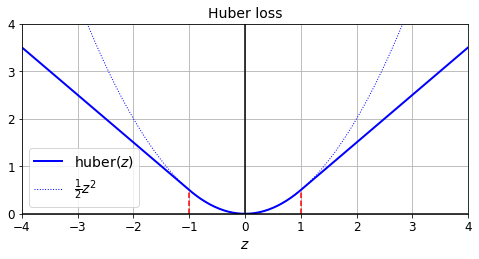

In [101]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()



And that’s it! For each batch during training, Keras will call the huber_fn() function to compute the loss and use it to perform a Gradient Descent step. Moreover, it will keep track of the total loss since the beginning of the epoch, and it will display the mean loss.

In [102]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [103]:
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])

In [104]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2


2023-04-04 21:16:48.788502: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x3767e090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-04 21:16:48.788531: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Quadro RTX 3000, Compute Capability 7.5
2023-04-04 21:16:48.829480: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-04 21:16:49.242123: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


363/363 [==============================] - 2s 3ms/step - loss: 0.5550 - mae: 0.9161 - val_loss: 0.2337 - val_mae: 0.5315
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2208 - mae: 0.5188 - val_loss: 0.2045 - val_mae: 0.4976




### Saving/Loading Models with Custom Objects

But what happens to this custom loss when you save the model?

Saving a model containing a custom loss function works fine, as Keras saves the name of the function. Whenever you load it, you’ll need to provide a dictionary that maps the function name to the actual function. More generally, when you load a model containing custom objects, you need to map the names to the objects.

In [106]:
model.save("trained_models/my_model_with_a_custom_loss.h5") 

In [107]:
model = keras.models.load_model("trained_models/my_model_with_a_custom_loss.h5",
                                custom_objects={"huber_fn": huber_fn})

In [108]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2069 - mae: 0.5005 - val_loss: 0.1915 - val_mae: 0.4775
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.1998 - mae: 0.4899 - val_loss: 0.2097 - val_mae: 0.4959


In [109]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [110]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])

In [112]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2125 - mae: 0.4780 - val_loss: 0.1955 - val_mae: 0.4582
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2094 - mae: 0.4732 - val_loss: 0.2204 - val_mae: 0.4761


In [113]:
model.save("trained_models/my_model_with_a_custom_loss_threshold_2.h5")

In [114]:
model = keras.models.load_model("trained_models/my_model_with_a_custom_loss_threshold_2.h5",
                                custom_objects={"huber_fn": create_huber(2.0)})

In [115]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 0.2066 - mae: 0.4695 - val_loss: 0.1930 - val_mae: 0.4529
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2044 - mae: 0.4660 - val_loss: 0.2190 - val_mae: 0.4718


In [116]:
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [117]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [118]:
model.compile(loss=HuberLoss(2.), optimizer="nadam", metrics=["mae"])

In [119]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 0.8050 - mae: 0.9523 - val_loss: 0.3326 - val_mae: 0.5465
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2391 - mae: 0.5083 - val_loss: 0.2492 - val_mae: 0.5021


In [120]:
model.save("trained_models/my_model_with_a_custom_loss_class.h5")

In [121]:
model = keras.models.load_model("trained_models/my_model_with_a_custom_loss_class.h5",
                                custom_objects={"HuberLoss": HuberLoss})

In [122]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2272 - mae: 0.4968 - val_loss: 0.2427 - val_mae: 0.4898
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2227 - mae: 0.4910 - val_loss: 0.2181 - val_mae: 0.4795


In [123]:
model.loss.threshold

2.0



### Custom Activation Functions, Initializers, Regularizers, and Constraints

Most Keras functionalities, such as losses, regularizers, constraints, initializers, metrics, activation functions, layers, and even full models, can be customized in very much the same way. Most of the time, you will justneed to write a simple function with the appropriate inputs and outputs.


In [124]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [125]:
# Here are examples of a custom activation function (equivalent to 
# keras.activations.softplus() or tf.nn.softplus()), a custom
# Glorot initializer (equivalent to keras.initializers.glorot_normal() ), 
# a custom ℓ 1 regularizer (equivalent to keras.regularizers.l1(0.01) ), 
# and a custom constraint that ensures weights are all positive (equivalent to
# keras.constraints.nonneg() or tf.nn.relu()).

def my_softplus(z): # return value is just tf.nn.softplus(z)
    return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights): # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [126]:
layer = keras.layers.Dense(1, activation=my_softplus,
                           kernel_initializer=my_glorot_initializer,
                           kernel_regularizer=my_l1_regularizer,
                           kernel_constraint=my_positive_weights)

In [127]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [128]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [129]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [131]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.5193 - mae: 0.4947 - val_loss: 0.7957 - val_mae: 0.4834
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.4979 - mae: 0.4872 - val_loss: 0.7586 - val_mae: 0.4855


In [132]:
model.save("trained_models/my_model_with_many_custom_parts.h5")

In [133]:
model = keras.models.load_model(
    "trained_models/my_model_with_many_custom_parts.h5",
    custom_objects={
       "my_l1_regularizer": my_l1_regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })



If a function has hyperparameters that need to be saved along with the model, then you will want to subclass the appropriate class, such as keras.regularizers.Regularizer, keras.constraints.Constraint, keras.initializers.Initializer, or keras.layers.Layer (for any layer, including activation functions). Much like we did for the custom loss, here is a simple class for _ℓ_ 1 regularization that saves its factor hyperparameter (this time we do not need to call the parent constructor or the get_config() method, as they are not defined by the parent class).

In [134]:
class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor
    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))
    def get_config(self):
        return {"factor": self.factor}

In [135]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [136]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=MyL1Regularizer(0.01),
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [137]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [138]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 1.7522 - mae: 0.9654 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.6208 - mae: 0.5337 - val_loss: inf - val_mae: inf


In [139]:
model.save("trained_models/my_model_with_many_custom_parts.h5")

In [140]:
model = keras.models.load_model(
    "trained_models/my_model_with_many_custom_parts.h5",
    custom_objects={
       "MyL1Regularizer": MyL1Regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })



### Custom Metrics

Losses and metrics are conceptually not the same thing: losses (e.g., cross entropy) are used by Gradient Descent to train a model, so they must be differentiable (at least where they are evaluated), and their gradients should not be 0 everywhere. Plus, it’s OK if they are not easily interpretable by humans. In contrast, metrics (e.g., accuracy) are used to evaluate a model: they must be more easily interpretable, and they can be non-differentiable or have 0 gradients everywhere.

That said, in most cases, defining a custom metric function is exactly the same as defining a custom loss function.

In [141]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [142]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [143]:
model.compile(loss="mse", optimizer="nadam", metrics=[create_huber(2.0)])

In [144]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 1.8975 - huber_fn: 0.8171
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.5310 - huber_fn: 0.2580


**Note**: if you use the same function as the loss and a metric, you may be surprised to see different results. This is generally just due to floating point precision errors: even though the mathematical equations are equivalent, the operations are not run in the same order, which can lead to small differences. Moreover, when using sample weights, there's more than just precision errors:
* the loss since the start of the epoch is the mean of all batch losses seen so far. Each batch loss is the sum of the weighted instance losses divided by the _batch size_ (not the sum of weights, so the batch loss is _not_ the weighted mean of the losses).
* the metric since the start of the epoch is equal to the sum of weighted instance losses divided by sum of all weights seen so far. In other words, it is the weighted mean of all the instance losses. Not the same thing.

If you do the math, you will find that loss = metric * mean of sample weights (plus some floating point precision error).

In [145]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[create_huber(2.0)])

In [146]:
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled, y_train, epochs=2, sample_weight=sample_weight)

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.1152 - huber_fn: 0.2342
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.1110 - huber_fn: 0.2254


In [147]:
history.history["loss"][0], history.history["huber_fn"][0] * sample_weight.mean()

(0.11521773040294647, 0.11623532250145789)



#### Streaming metrics

For each batch during training, Keras will compute this metric and keep track of its mean since the beginning of the epoch. Most of the time, this is exactly what you want. But not always! Consider a binary classifier’s precision, for example. As we saw in, precision is the number of true positives divided by the number of positive predictions (including both true positives and false positives). Suppose the model made five positive predictions in the first batch, four of which were correct: that’s 80% precision. Then suppose the model made three positive predictions in the second batch, but they were all incorrect: that’s 0% precision for the second batch. If you just compute the mean of these two precisions, yo get 40%. But wait a second—that’s not the model’s precision over these two batches! Indeed, there were a total of four true positives (4 + 0) out of eight positive predictions (5 + 3), so the overall precision is 50%, not 40%. What we need is an object that can keep track of the number of true positives and the number of false positives and that can compute their ratio when requested. This is precisely what the keras.metrics.Precision class does.

In the example below, we created a Precision object, then we used it like a function, passing it the labels and predictions for the first batch, then for the second batch (note that we could also have passed sample weights). We used the same number of true and false positives as in the example we just discussed. After the first batch, it returns a precision of 80%; then after these scond batch, it returns 50% (which is the overall precision so far, not the second batch’s precision). This is called a streaming metric (or stateful metric), as it is gradually updated, batch after batch.

In [106]:
precision = keras.metrics.Precision()
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.8>

In [107]:
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [108]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [109]:
precision.variables

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>]

In [110]:
precision.reset_states()



Creating a streaming metric:

If you need to create such a streaming metric, create a subclass of the keras.metrics.Metric class. Here is a simple example that keeps track of the total Huber loss and the number of instances seen so far. When asked for the result, it returns the ratio, which is simply the mean Huber loss.

In [148]:
class HuberMetric(keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs) # handles base args (e.g., dtype)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
    def result(self):
        return self.total / self.count
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [149]:
m = HuberMetric(2.)

# total = 2 * |10 - 2| - 2²/2 = 14
# count = 1
# result = 14 / 1 = 14
m(tf.constant([[2.]]), tf.constant([[10.]])) 

<tf.Tensor: shape=(), dtype=float32, numpy=14.0>

In [150]:
# total = total + (|1 - 0|² / 2) + (2 * |9.25 - 5| - 2² / 2) = 14 + 7 = 21
# count = count + 2 = 3
# result = total / count = 21 / 3 = 7
m(tf.constant([[0.], [5.]]), tf.constant([[1.], [9.25]]))

m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=7.0>

In [151]:
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=21.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=3.0>]

In [152]:
m.reset_states()
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=0.0>]

Let's check that the `HuberMetric` class works well:

In [153]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [154]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [155]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[HuberMetric(2.0)])

In [119]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 592us/step - loss: 1.5182 - huber_metric: 1.5182
Epoch 2/2
363/363 [==============================] - 0s 538us/step - loss: 0.2909 - huber_metric: 0.2909


In [156]:
model.save("trained_models/my_model_with_a_custom_metric.h5")

In [157]:
model = keras.models.load_model("trained_models/my_model_with_a_custom_metric.h5",
                                custom_objects={"huber_fn": create_huber(2.0),
                                                "HuberMetric": HuberMetric})

In [158]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.8630 - huber_metric: 0.8630
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2536 - huber_metric: 0.2536


**Warning**: In TF 2.2, tf.keras adds an extra first metric in `model.metrics` at position 0 (see [TF issue #38150](https://github.com/tensorflow/tensorflow/issues/38150)). This forces us to use `model.metrics[-1]` rather than `model.metrics[0]` to access the `HuberMetric`.

In [159]:
model.metrics[-1].threshold

2.0

Looks like it works fine! More simply, we could have created the class like this:

In [160]:
class HuberMetric(keras.metrics.Mean):
    def __init__(self, threshold=1.0, name='HuberMetric', dtype=None):
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        super().__init__(name=name, dtype=dtype)
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        super(HuberMetric, self).update_state(metric, sample_weight)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}        

This class handles shapes better, and it also supports sample weights.

In [161]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [162]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [163]:
model.compile(loss=keras.losses.Huber(2.0), optimizer="nadam", weighted_metrics=[HuberMetric(2.0)])

In [164]:
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32),
                    epochs=2, sample_weight=sample_weight)

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.4242 - HuberMetric: 0.8548
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.1206 - HuberMetric: 0.2429


In [165]:
history.history["loss"][0], history.history["HuberMetric"][0] * sample_weight.mean()

(0.4241766035556793, 0.4241766501176932)

In [166]:
model.save("trained_models/my_model_with_a_custom_metric_v2.h5")

In [167]:
model = keras.models.load_model("trained_models/my_model_with_a_custom_metric_v2.h5",
                                custom_objects={"HuberMetric": HuberMetric})

In [168]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2285 - HuberMetric: 0.2285
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2209 - HuberMetric: 0.2209


In [169]:
model.metrics[-1].threshold

2.0



### Custom Layers

You may occasionally want to build an architecture that contains an exotic layer for which TensorFlow does not provide a default implementation. In this case, you will need to create a custom layer. Or you may simply want to build a very repetitive architecture, containing identical blocks of layers repeated many times, and it would be convenient to treat each block of layers as a single layer. For example, if the model is a sequence of layers A, B, C, A, B, C, A, B, C, then you might want to define a custom layer D containing layers A, B, C, so your model would then simply be D, D, D.

First, some layers have no weights, such as keras.layers.Flatten or keras.layers.ReLU . If you want to create a custom layer without any weights, the simplest option is to write a function and wrap it in a keras.layers.Lambda layer. For example, the following layer will apply the exponential function to its inputs.

In [170]:
exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))

In [171]:
exponential_layer([-1., 0., 1.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.36787948, 1.        , 2.7182817 ], dtype=float32)>

Adding an exponential layer at the output of a regression model can be useful if the values to predict are positive and with very different scales (e.g., 0.001, 10., 10000):

In [172]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [173]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    keras.layers.Dense(1),
    exponential_layer
])
model.compile(loss="mse", optimizer="sgd")
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/5
363/363 [==============================] - 1s 2ms/step - loss: 4.0709 - val_loss: 1.7735
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 1.3811 - val_loss: 0.9533
Epoch 3/5
363/363 [==============================] - 1s 2ms/step - loss: 0.8270 - val_loss: 0.5539
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 0.6024 - val_loss: 0.4272
Epoch 5/5
162/162 [==============================] - 0s 1ms/step - loss: 0.4165


0.416515588760376



To build a custom stateful layer (i.e., a layer with weights), you need to create a subclass of thekeras.layers.Layer class. For example, the following class implements a simplified version of the Dense layer.

- The constructor takes all the hyperparameters as arguments (in this example, units and activation ), and importantly it also takes a \*\*kwargs argument. It calls the parent constructor, passing it the kwargs : this takes care of standard arguments such as input_shape , trainable , and name . Then it saves the hyperparameters as attributes, converting the activation argument to the appropriate activation function using the keras.activations.get() function (it accepts functions, standard strings like "relu" or "selu" , or simply None ).

- The build() method’s role is to create the layer’s variables by calling the add_weight() method for each weight. The build() method is called the first time the layer is used. At that point, Keras will know the shape of this layer’s inputs, and it will pass it to the build() method, 9 which is often necessary to create some of the weights. For example, we need to know the number of neurons in the previous layer in order to create the connection weights matrix (i.e., the "kernel" ): this corresponds to the size of the last dimension of the inputs. At the end of the build() method (and only at the end), you must call the parent’s build() method: this tells Keras that the layer is built (it just sets self.built=True ).

- The call() method performs the desired operations. In this case, we compute the matrix multiplication of the inputs X and the layer’s kernel, we add the bias vector, and we apply the activation function to the result, and this gives us the output of the layer.

- The compute_output_shape() method simply returns the shape of this layer’s outputs. In this case, it is the same shape as the inputs, except the last dimension is replaced with the number of neurons in the layer. Note that in tf.keras, shapes are instances of the tf.TensorShape class, which you can convert to Python lists using as_list().

- The get_config() method is just like in the previous custom classes. Note that we save the activation function’s full configuration by calling keras.activations.serialize().

In [182]:
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="glorot_normal")
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")
        super().build(batch_input_shape) # must be at the end

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": keras.activations.serialize(self.activation)}

In [183]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [184]:
model = keras.models.Sequential([
    MyDense(30, activation="relu", input_shape=input_shape),
    MyDense(1)
])

In [185]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 1.5357 - val_loss: 0.7168
Epoch 2/2
162/162 [==============================] - 0s 1ms/step - loss: 0.4736


0.4736383855342865

In [186]:
model.save("trained_models/my_model_with_a_custom_layer.h5")

In [187]:
model = keras.models.load_model("trained_models/my_model_with_a_custom_layer.h5",
                                custom_objects={"MyDense": MyDense})

In [188]:
class MyMultiLayer(keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        print("X1.shape: ", X1.shape ," X2.shape: ", X2.shape) # Debugging of custom layer
        return X1 + X2, X1 * X2

    def compute_output_shape(self, batch_input_shape):
        batch_input_shape1, batch_input_shape2 = batch_input_shape
        return [batch_input_shape1, batch_input_shape2]

Our custom layer can be called using the functional API like this:

In [189]:
inputs1 = keras.layers.Input(shape=[2])
inputs2 = keras.layers.Input(shape=[2])
outputs1, outputs2 = MyMultiLayer()((inputs1, inputs2))

X1.shape:  (None, 2)  X2.shape:  (None, 2)


Note that the `call()` method receives symbolic inputs, whose shape is only partially specified (at this stage, we don't know the batch size, which is why the first dimension is `None`):

We can also pass actual data to the custom layer. To test this, let's split each dataset's inputs into two parts, with four features each:

In [190]:
def split_data(data):
    columns_count = data.shape[-1]
    half = columns_count // 2
    return data[:, :half], data[:, half:]

X_train_scaled_A, X_train_scaled_B = split_data(X_train_scaled)
X_valid_scaled_A, X_valid_scaled_B = split_data(X_valid_scaled)
X_test_scaled_A, X_test_scaled_B = split_data(X_test_scaled)

# Printing the splitted data shapes
X_train_scaled_A.shape, X_train_scaled_B.shape

((11610, 4), (11610, 4))

Now notice that the shapes are fully specified:

In [191]:
outputs1, outputs2 = MyMultiLayer()((X_train_scaled_A, X_train_scaled_B))

X1.shape:  (11610, 4)  X2.shape:  (11610, 4)


Let's build a more complete model using the functional API (this is just a toy example, don't expect awesome performance):

In [192]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

input_A = keras.layers.Input(shape=X_train_scaled_A.shape[-1])
input_B = keras.layers.Input(shape=X_train_scaled_B.shape[-1])
hidden_A, hidden_B = MyMultiLayer()((input_A, input_B))
hidden_A = keras.layers.Dense(30, activation='selu')(hidden_A)
hidden_B = keras.layers.Dense(30, activation='selu')(hidden_B)
concat = keras.layers.Concatenate()((hidden_A, hidden_B))
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

X1.shape:  (None, 4)  X2.shape:  (None, 4)


In [193]:
model.compile(loss='mse', optimizer='nadam')

In [194]:
model.fit((X_train_scaled_A, X_train_scaled_B), y_train, epochs=2,
          validation_data=((X_valid_scaled_A, X_valid_scaled_B), y_valid))

Epoch 1/2
X1.shape:  (None, 4)  X2.shape:  (None, 4)
X1.shape:  (None, 4)  X2.shape:  (None, 4)
363/363 [==============================] - 2s 3ms/step - loss: 3.0484 - val_loss: 23.7909
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 1.5111 - val_loss: 9.7750


Now let's create a layer with a different behavior during training and testing:

In [195]:
class AddGaussianNoise(keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

Here's a simple model that uses this custom layer:

In [196]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    AddGaussianNoise(stddev=1.0),
    keras.layers.Dense(30, activation="selu"),
    keras.layers.Dense(1)
])

In [197]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 2.1898 - val_loss: 0.7901
Epoch 2/2
162/162 [==============================] - 0s 1ms/step - loss: 0.7405


0.7405170202255249




### Custom Models

Creating custom model classes is nothing but the Subclassing API. It’s straightforward: subclass the keras.Model class, create layers and variables in the constructor, and implement the call() method to do whatever you want the model to do.

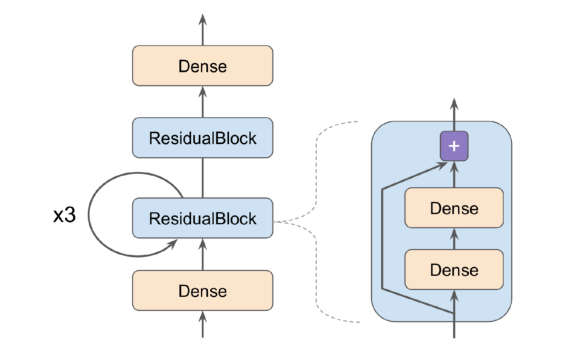

In [199]:
from matplotlib import image as mpimg

image = mpimg.imread(RESOURCE_DIR + '/residual.png')
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(image)


The inputs go through a first dense layer, then through a residual block composed of two dense layers and an addition operation (a residual block adds its inputs to its outputs), then through this same residual block three more times, then through a second residual block, and the final result goes through a dense output layer. Note that this model does not make much sense; it’s just an example to illustrate the fact that you can easily build any kind of model you want, even one that contains loops and skip connections.

In [200]:
X_new_scaled = X_test_scaled

In [201]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons, activation="elu",
                                          kernel_initializer="he_normal")
                       for _ in range(n_layers)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z

In [202]:
class ResidualRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30, activation="elu",
                                          kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

In [203]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [204]:
model = ResidualRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Epoch 1/5
363/363 [==============================] - 3s 3ms/step - loss: 13.0450
Epoch 2/5
363/363 [==============================] - 1s 3ms/step - loss: 1.7879
Epoch 3/5
363/363 [==============================] - 1s 3ms/step - loss: 0.8072
Epoch 4/5
363/363 [==============================] - 1s 4ms/step - loss: 0.9934
Epoch 5/5
162/162 [==============================] - 0s 1ms/step


In [205]:
model.save("trained_models/my_custom_model.ckpt")

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 30), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f16743d9c10>, 139734416480272), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f167444c5e0>, 139734416479408), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 30), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f16743922e0>, 139734416707968), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f167433a190>, 139734416707632), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 30), dtype=tf.

INFO:tensorflow:Assets written to: trained_models/my_custom_model.ckpt/assets


INFO:tensorflow:Assets written to: trained_models/my_custom_model.ckpt/assets


In [206]:
model = keras.models.load_model("trained_models/my_custom_model.ckpt")

In [207]:
history = model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
363/363 [==============================] - 3s 4ms/step - loss: 1.1567
Epoch 2/5
363/363 [==============================] - 1s 4ms/step - loss: 1.0229
Epoch 3/5
363/363 [==============================] - 1s 4ms/step - loss: 0.7944
Epoch 4/5
363/363 [==============================] - 2s 5ms/step - loss: 0.4038
Epoch 5/5
363/363 [==============================] - 1s 3ms/step - loss: 0.5469


We could have defined the model using the sequential API instead:

In [208]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [209]:
block1 = ResidualBlock(2, 30)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal"),
    block1, block1, block1, block1,
    ResidualBlock(2, 30),
    keras.layers.Dense(1)
])

In [210]:
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Epoch 1/5
363/363 [==============================] - 3s 3ms/step - loss: 1.3691
Epoch 2/5
363/363 [==============================] - 1s 3ms/step - loss: 0.6544
Epoch 3/5
363/363 [==============================] - 1s 3ms/step - loss: 0.6523
Epoch 4/5
363/363 [==============================] - 1s 3ms/step - loss: 0.4001
Epoch 5/5
162/162 [==============================] - 0s 936us/step





### Losses and Metrics Based on Model Internals

The custom losses and metrics we defined earlier were all based on the labels and the predictions (and optionally sample weights). There will be times when you want to define losses based on other parts of your model, such as the weights or activations of its hidden layers. This may be useful for regularization purposes or to monitor some internal aspect of your model.

To define a custom loss based on model internals, compute it based on any part of the model you want, then pass the result to the add_loss()method.For example, let’s build a custom regression MLP (_multi-layer perceptron_) model  composed of a stack of five hidden layers plus an output layer. This custom model will also have an auxiliary output on top of the upper hidden layer. 

The loss associated to this auxiliary output will be called the reconstruction loss: it is the mean squared difference between the reconstruction and the inputs. By adding this reconstruction loss to the main loss, we will encourage the model to preserve as much information as possible through the hidden layers—even information that is not directly useful for the regression task itself. In practice, this loss sometimes improves generalization (it is a regularization loss).

**Note**: the following code has two differences with the code in the book:
1. It creates a `keras.metrics.Mean()` metric in the constructor and uses it in the `call()` method to track the mean reconstruction loss. Since we only want to do this during training, we add a `training` argument to the `call()` method, and if `training` is `True`, then we update `reconstruction_mean` and we call `self.add_metric()` to ensure it's displayed properly.
2. Due to an issue introduced in TF 2.2 ([#46858](https://github.com/tensorflow/tensorflow/issues/46858)), we must not call `super().build()` inside the `build()` method.

In [214]:
class ReconstructingRegressor(keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(30, activation="selu",
                                          kernel_initializer="lecun_normal")
                       for _ in range(5)]
        self.out = keras.layers.Dense(output_dim)
        self.reconstruction_mean = keras.metrics.Mean(name="reconstruction_error")

    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        self.reconstruct = keras.layers.Dense(n_inputs)
        #super().build(batch_input_shape)

    def call(self, inputs, training=None):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        recon_loss = tf.reduce_mean(tf.square(reconstruction - inputs))
        self.add_loss(0.05 * recon_loss)
        if training:
            result = self.reconstruction_mean(recon_loss)
            self.add_metric(result)
        return self.out(Z)



- The constructor creates the DNN with five dense hidden layers and one dense output layer.The build() method creates an extra dense layer which will be used to reconstruct the inputs of the model. It must be created here because its number of units must be equal to the number of inputs, and this number is unknown before the build() method is called.

- The call() method processes the inputs through all five hidden layers, then passes the result through the reconstruction layer, which produces the reconstruction. 

- Then the call() method computes the reconstruction loss (the mean squared difference between the reconstruction and the inputs), and adds it to the model’s list of losses using the add_loss() method. Notice that we scale down the reconstruction loss by multiplying it by 0.05 (this is a hyperparameter you can tune). This ensures that the reconstruction loss does not dominate the main loss.

- Finally, the call() method passes the output of the hidden layers to the output layer and returns its output.

In [215]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [216]:
model = ReconstructingRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=2)
y_pred = model.predict(X_test_scaled)

Epoch 1/2
363/363 [==============================] - 3s 4ms/step - loss: 0.7944 - reconstruction_error: 1.0253
Epoch 2/2
162/162 [==============================] - 0s 1ms/step





### Computing Gradients with Autodiff


In [217]:
def f(w1, w2):
    return 3 * w1 ** 2 + 2 * w1 * w2

In [218]:
w1, w2 = 5, 3
eps = 1e-6
(f(w1 + eps, w2) - f(w1, w2)) / eps

36.000003007075065

In [219]:
(f(w1, w2 + eps) - f(w1, w2)) / eps

10.000000003174137

In [220]:
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)

gradients = tape.gradient(z, [w1, w2])

In [221]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [222]:
with tf.GradientTape() as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
try:
    dz_dw2 = tape.gradient(z, w2)
except RuntimeError as ex:
    print(ex)

A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)


In [223]:
with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
dz_dw2 = tape.gradient(z, w2) # works now!
del tape

In [224]:
dz_dw1, dz_dw2

(<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>)

In [225]:
c1, c2 = tf.constant(5.), tf.constant(3.)
with tf.GradientTape() as tape:
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

In [226]:
gradients

[None, None]

In [227]:
with tf.GradientTape() as tape:
    tape.watch(c1)
    tape.watch(c2)
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

In [228]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [229]:
with tf.GradientTape() as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tape.gradient([z1, z2, z3], [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=136.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.0>]

In [230]:
with tf.GradientTape(persistent=True) as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tf.reduce_sum(tf.stack([tape.gradient(z, [w1, w2]) for z in (z1, z2, z3)]), axis=0)
del tape

In [231]:
with tf.GradientTape(persistent=True) as hessian_tape:
    with tf.GradientTape() as jacobian_tape:
        z = f(w1, w2)
    jacobians = jacobian_tape.gradient(z, [w1, w2])
hessians = [hessian_tape.gradient(jacobian, [w1, w2])
            for jacobian in jacobians]
del hessian_tape

In [232]:
jacobians

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [233]:
hessians

[[<tf.Tensor: shape=(), dtype=float32, numpy=6.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.0>],
 [<tf.Tensor: shape=(), dtype=float32, numpy=2.0>, None]]

In [234]:
def f(w1, w2):
    return 3 * w1 ** 2 + tf.stop_gradient(2 * w1 * w2)

with tf.GradientTape() as tape:
    z = f(w1, w2)

tape.gradient(z, [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=30.0>, None]

In [235]:
x = tf.Variable(100.)
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(), dtype=float32, numpy=nan>]

In [236]:
tf.math.log(tf.exp(tf.constant(30., dtype=tf.float32)) + 1.)

<tf.Tensor: shape=(), dtype=float32, numpy=30.0>

In [237]:
x = tf.Variable([100.])
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>]

In [238]:
@tf.custom_gradient
def my_better_softplus(z):
    exp = tf.exp(z)
    def my_softplus_gradients(grad):
        return grad / (1 + 1 / exp)
    return tf.math.log(exp + 1), my_softplus_gradients

In [239]:
def my_better_softplus(z):
    return tf.where(z > 30., z, tf.math.log(tf.exp(z) + 1.))

In [240]:
x = tf.Variable([1000.])
with tf.GradientTape() as tape:
    z = my_better_softplus(x)

z, tape.gradient(z, [x])

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1000.], dtype=float32)>,
 [<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>])




### Custom Training Loops

In some rare cases, the fit() method may not be flexible enough for what you need to do. Since the fit() method only uses one optimizer (the one that we specify when compiling the model), some implementations uses two different optimizers. Hence custom loops are required.

You may also like to write custom training loops simply to feel more confident that they do precisely what you intend them to do (perhaps you are unsure about some details of the fit() method). It can sometimes feel safer to make everything explicit.

In [241]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [242]:
l2_reg = keras.regularizers.l2(0.05)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal",
                       kernel_regularizer=l2_reg),
    keras.layers.Dense(1, kernel_regularizer=l2_reg)
])

In [243]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

In [244]:
def print_status_bar(iteration, total, loss, metrics=None):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{}/{} - ".format(iteration, total) + metrics,
          end=end)

In [245]:
import time

mean_loss = keras.metrics.Mean(name="loss")
mean_square = keras.metrics.Mean(name="mean_square")
for i in range(1, 50 + 1):
    loss = 1 / i
    mean_loss(loss)
    mean_square(i ** 2)
    print_status_bar(i, 50, mean_loss, [mean_square])
    time.sleep(0.05)

50/50 - loss: 0.0900 - mean_square: 858.5000


A fancier version with a progress bar:

In [246]:
def progress_bar(iteration, total, size=30):
    running = iteration < total
    c = ">" if running else "="
    p = (size - 1) * iteration // total
    fmt = "{{:-{}d}}/{{}} [{{}}]".format(len(str(total)))
    params = [iteration, total, "=" * p + c + "." * (size - p - 1)]
    return fmt.format(*params)

In [247]:
progress_bar(3500, 10000, size=6)

' 3500/10000 [=>....]'

In [248]:
def print_status_bar(iteration, total, loss, metrics=None, size=30):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{} - {}".format(progress_bar(iteration, total), metrics), end=end)

In [249]:
mean_loss = keras.metrics.Mean(name="loss")
mean_square = keras.metrics.Mean(name="mean_square")
for i in range(1, 50 + 1):
    loss = 1 / i
    mean_loss(loss)
    mean_square(i ** 2)
    print_status_bar(i, 50, mean_loss, [mean_square])
    time.sleep(0.05)

50/50 [==============================] - loss: 0.0900 - mean_square: 858.5000


In [250]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [251]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.mean_squared_error
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.MeanAbsoluteError()]

In [252]:
for epoch in range(1, n_epochs + 1):
    print("Epoch {}/{}".format(epoch, n_epochs))
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train_scaled, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        for variable in model.variables:
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))
        mean_loss(loss)
        for metric in metrics:
            metric(y_batch, y_pred)
        print_status_bar(step * batch_size, len(y_train), mean_loss, metrics)
    print_status_bar(len(y_train), len(y_train), mean_loss, metrics)
    for metric in [mean_loss] + metrics:
        metric.reset_states()

Epoch 1/5
11610/11610 [==============================] - mean: 1.7270 - mean_absolute_error: 0.57851
Epoch 2/5
11610/11610 [==============================] - mean: 0.7437 - mean_absolute_error: 0.5247
Epoch 3/5
11610/11610 [==============================] - mean: 0.6483 - mean_absolute_error: 0.5165
Epoch 4/5
11610/11610 [==============================] - mean: 0.6435 - mean_absolute_error: 0.5180
Epoch 5/5
11610/11610 [==============================] - mean: 0.6505 - mean_absolute_error: 0.5238


- We create two nested loops: one for the epochs, the other for the batches within an epoch. 

- Then we sample a random batch from the training set.

- Inside the tf.GradientTape() block, we make a prediction for one batch (using the model as a function), and we compute the loss: it is equal to the main loss plus the other losses (in this model, there is one regularization loss per layer). Since the mean_squared_error() function returns one loss per instance, we compute the mean over the batch using tf.reduce_mean() (if you wanted to apply different weights to each instance, this is where you would do it). The regularization losses are already reduced to a single scalar each, so we just need to sum them (using tf.add_n() , which sums multiple tensors of the same shape and data type).

- Next, we ask the tape to compute the gradient of the loss with regard to each trainable variable (not all variables!), and we apply them to the optimizer to perform a Gradient Descent step. 

- Then we update the mean loss and the metrics (over the current epoch), and we display the status bar.

- At the end of each epoch, we display the status bar again to make it look complete 13 and to print a line feed, and we reset the states of the mean loss and the metrics.

In [204]:
try:
    from tqdm.notebook import trange
    from collections import OrderedDict
    with trange(1, n_epochs + 1, desc="All epochs") as epochs:
        for epoch in epochs:
            with trange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs)) as steps:
                for step in steps:
                    X_batch, y_batch = random_batch(X_train_scaled, y_train)
                    with tf.GradientTape() as tape:
                        y_pred = model(X_batch)
                        main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                        loss = tf.add_n([main_loss] + model.losses)
                    gradients = tape.gradient(loss, model.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                    for variable in model.variables:
                        if variable.constraint is not None:
                            variable.assign(variable.constraint(variable))                    
                    status = OrderedDict()
                    mean_loss(loss)
                    status["loss"] = mean_loss.result().numpy()
                    for metric in metrics:
                        metric(y_batch, y_pred)
                        status[metric.name] = metric.result().numpy()
                    steps.set_postfix(status)
            for metric in [mean_loss] + metrics:
                metric.reset_states()
except ImportError as ex:
    print("To run this cell, please install tqdm, ipywidgets and restart Jupyter")

All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/362 [00:00<?, ?it/s]




## TensorFlow Functions


In TensorFlow 1, graphs were unavoidable (as were the complexities that came with them) because they were a central part of TensorFlow’s API. In TensorFlow 2, they are still there, but not as central, and they’re much (much!) simpler to use. To show just how simple, let’s start with a trivial function that computes the cube of its input.

We can obviously call this function with a Python value, such as an int or a float, or we can call it with a tensor.

In [253]:
def cube(x):
    return x ** 3

In [254]:
cube(2)

8

In [255]:
cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>



Now, let’s use tf.function() to convert this Python function to a **TensorFlow Function**.
This TF Function can then be used exactly like the original Python function, and it will return the same result (but as tensors).

Under the hood, tf.function() analyzed the computations performed by the cube() function and generated an equivalent computation graph! As you can see, it was rather painless. Alternatively, we could have used tf.function as a decorator; this is actually more common.

In [259]:
tf_cube = tf.function(cube)
tf_cube

In [260]:
tf_cube(2)

<tf.Tensor: shape=(), dtype=int32, numpy=8>

In [261]:
tf_cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>


#### TF Functions and Concrete Functions

In [262]:
concrete_function = tf_cube.get_concrete_function(tf.constant(2.0))
concrete_function.graph

In [263]:
concrete_function(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [264]:
concrete_function is tf_cube.get_concrete_function(tf.constant(2.0))

True


#### Exploring Function Definitions and Graphs

In [265]:
concrete_function.graph

In [266]:
ops = concrete_function.graph.get_operations()
ops

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'pow/y' type=Const>,
 <tf.Operation 'pow' type=Pow>,
 <tf.Operation 'Identity' type=Identity>]

In [216]:
pow_op = ops[2]
list(pow_op.inputs)

[<tf.Tensor 'x:0' shape=() dtype=float32>,
 <tf.Tensor 'pow/y:0' shape=() dtype=float32>]

In [217]:
pow_op.outputs

[<tf.Tensor 'pow:0' shape=() dtype=float32>]

In [218]:
concrete_function.graph.get_operation_by_name('x')

<tf.Operation 'x' type=Placeholder>

In [219]:
concrete_function.graph.get_tensor_by_name('Identity:0')

<tf.Tensor 'Identity:0' shape=() dtype=float32>

In [220]:
concrete_function.function_def.signature

name: "__inference_cube_1073862"
input_arg {
  name: "x"
  type: DT_FLOAT
}
output_arg {
  name: "identity"
  type: DT_FLOAT
}




### Autograph and Tracing



So how does TensorFlow generate graphs? It starts by analyzing the Python function’s source code to capture all the control flow statements, such as for loops, while loops, and if statements, as well as break , continue , and return statements. This first step is called _AutoGraph_. The reason TensorFlow has to analyze the source code is that Python does not provide any other way to capture control flow statements: it offers magic methods like __add__() and __mul__() to capture operators like + and \*, but there are no __while__() or __if__() magic methods. After analyzing the function’s code, AutoGraph outputs an upgraded version of that function in which all the control flow statements are replaced by the appropriate TensorFlow operations, such as tf.while_loop() for loops and tf.cond() for if statements.

#### How TF Functions Trace Python Functions to Extract Their Computation Graphs

In [275]:
@tf.function
def tf_cube(x):
    print("print:", x)
    return x ** 3

In [276]:
result = tf_cube(tf.constant(2.0))

print: Tensor("x:0", shape=(), dtype=float32)


In [277]:
result

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [278]:
result = tf_cube(2)
result = tf_cube(3)
result = tf_cube(tf.constant([[1., 2.]])) # New shape: trace!
result = tf_cube(tf.constant([[3., 4.], [5., 6.]])) # New shape: trace!
result = tf_cube(tf.constant([[7., 8.], [9., 10.], [11., 12.]])) # New shape: trace!


print: 2
print: 3
print: Tensor("x:0", shape=(1, 2), dtype=float32)
print: Tensor("x:0", shape=(2, 2), dtype=float32)


print: Tensor("x:0", shape=(3, 2), dtype=float32)


It is also possible to specify a particular input signature:

In [279]:
@tf.function(input_signature=[tf.TensorSpec([None, 28, 28], tf.float32)])
def shrink(images):
    print("Tracing", images)
    return images[:, ::2, ::2] # drop half the rows and columns

In [280]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [281]:
img_batch_1 = tf.random.uniform(shape=[100, 28, 28])
img_batch_2 = tf.random.uniform(shape=[50, 28, 28])
preprocessed_images = shrink(img_batch_1) # Traces the function.
preprocessed_images = shrink(img_batch_2) # Reuses the same concrete function.

Tracing Tensor("images:0", shape=(None, 28, 28), dtype=float32)


In [282]:
img_batch_3 = tf.random.uniform(shape=[2, 2, 2])
try:
    preprocessed_images = shrink(img_batch_3)  # rejects unexpected types or shapes
except ValueError as ex:
    print(ex)

Python inputs incompatible with input_signature:
  inputs: (
    tf.Tensor(
[[[0.7413678  0.62854624]
  [0.01738465 0.3431449 ]]

 [[0.51063764 0.3777541 ]
  [0.07321596 0.02137029]]], shape=(2, 2, 2), dtype=float32))
  input_signature: (
    TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None)).



#### Using Autograph To Capture Control Flow

A "static" `for` loop using `range()`:

In [283]:
@tf.function
def add_10(x):
    for i in range(10):
        x += 1
    return x

In [284]:
add_10(tf.constant(5))

<tf.Tensor: shape=(), dtype=int32, numpy=15>

In [285]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'add/y' type=Const>,
 <tf.Operation 'add' type=AddV2>,
 <tf.Operation 'add_1/y' type=Const>,
 <tf.Operation 'add_1' type=AddV2>,
 <tf.Operation 'add_2/y' type=Const>,
 <tf.Operation 'add_2' type=AddV2>,
 <tf.Operation 'add_3/y' type=Const>,
 <tf.Operation 'add_3' type=AddV2>,
 <tf.Operation 'add_4/y' type=Const>,
 <tf.Operation 'add_4' type=AddV2>,
 <tf.Operation 'add_5/y' type=Const>,
 <tf.Operation 'add_5' type=AddV2>,
 <tf.Operation 'add_6/y' type=Const>,
 <tf.Operation 'add_6' type=AddV2>,
 <tf.Operation 'add_7/y' type=Const>,
 <tf.Operation 'add_7' type=AddV2>,
 <tf.Operation 'add_8/y' type=Const>,
 <tf.Operation 'add_8' type=AddV2>,
 <tf.Operation 'add_9/y' type=Const>,
 <tf.Operation 'add_9' type=AddV2>,
 <tf.Operation 'Identity' type=Identity>]

A "dynamic" loop using `tf.while_loop()`:

In [286]:
@tf.function
def add_10(x):
    condition = lambda i, x: tf.less(i, 10)
    body = lambda i, x: (tf.add(i, 1), tf.add(x, 1))
    final_i, final_x = tf.while_loop(condition, body, [tf.constant(0), x])
    return final_x

In [287]:
add_10(tf.constant(5))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


<tf.Tensor: shape=(), dtype=int32, numpy=15>

In [288]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'Const' type=Const>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=StatelessWhile>,
 <tf.Operation 'Identity' type=Identity>]

A "dynamic" `for` loop using `tf.range()` (captured by autograph):

In [289]:
@tf.function
def add_10(x):
    for i in tf.range(10):
        x = x + 1
    return x

In [290]:
add_10.get_concrete_function(tf.constant(0)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'range/start' type=Const>,
 <tf.Operation 'range/limit' type=Const>,
 <tf.Operation 'range/delta' type=Const>,
 <tf.Operation 'range' type=Range>,
 <tf.Operation 'sub' type=Sub>,
 <tf.Operation 'floordiv' type=FloorDiv>,
 <tf.Operation 'mod' type=FloorMod>,
 <tf.Operation 'zeros_like' type=Const>,
 <tf.Operation 'NotEqual' type=NotEqual>,
 <tf.Operation 'Cast' type=Cast>,
 <tf.Operation 'add' type=AddV2>,
 <tf.Operation 'zeros_like_1' type=Const>,
 <tf.Operation 'Maximum' type=Maximum>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=StatelessWhile>,
 <tf.Operation 'Identity' type=Identity>]




### TF Functions Rules

Most of the time, converting a Python function that performs TensorFlow operations into a TF Function is trivial: decorate it with @tf.function or let Keras take care of it for you. However, there are a few rules to respect.

In [291]:
counter = tf.Variable(0)

@tf.function
def increment(counter, c=1):
    return counter.assign_add(c)

In [292]:
increment(counter)
increment(counter)

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [293]:
function_def = increment.get_concrete_function(counter).function_def
function_def.signature.input_arg[0]

name: "counter"
type: DT_RESOURCE

In [294]:
counter = tf.Variable(0)

@tf.function
def increment(c=1):
    return counter.assign_add(c)

In [295]:
increment()
increment()

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [296]:
function_def = increment.get_concrete_function().function_def
function_def.signature.input_arg[0]

name: "assignaddvariableop_resource"
type: DT_RESOURCE

In [297]:
class Counter:
    def __init__(self):
        self.counter = tf.Variable(0)

    @tf.function
    def increment(self, c=1):
        return self.counter.assign_add(c)

In [298]:
c = Counter()
c.increment()
c.increment()

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [299]:
@tf.function
def add_10(x):
    for i in tf.range(10):
        x += 1
    return x

print(tf.autograph.to_code(add_10.python_function))

def tf__add(x):
    with ag__.FunctionScope('add_10', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()

        def get_state():
            return (x,)

        def set_state(vars_):
            nonlocal x
            (x,) = vars_

        def loop_body(itr):
            nonlocal x
            i = itr
            x = ag__.ld(x)
            x += 1
        i = ag__.Undefined('i')
        ag__.for_stmt(ag__.converted_call(ag__.ld(tf).range, (10,), None, fscope), None, loop_body, get_state, set_state, ('x',), {'iterate_names': 'i'})
        try:
            do_return = True
            retval_ = ag__.ld(x)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)



In [300]:
def display_tf_code(func):
    from IPython.display import display, Markdown
    if hasattr(func, "python_function"):
        func = func.python_function
    code = tf.autograph.to_code(func)
    display(Markdown('```python\n{}\n```'.format(code)))

In [301]:
display_tf_code(add_10)

```python
def tf__add(x):
    with ag__.FunctionScope('add_10', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()

        def get_state():
            return (x,)

        def set_state(vars_):
            nonlocal x
            (x,) = vars_

        def loop_body(itr):
            nonlocal x
            i = itr
            x = ag__.ld(x)
            x += 1
        i = ag__.Undefined('i')
        ag__.for_stmt(ag__.converted_call(ag__.ld(tf).range, (10,), None, fscope), None, loop_body, get_state, set_state, ('x',), {'iterate_names': 'i'})
        try:
            do_return = True
            retval_ = ag__.ld(x)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)

```



#### Using TF Functions with tf.keras (or Not)


By default, tf.keras will automatically convert your custom code into TF Functions, no need to use
`tf.function()`:

In [302]:
# Custom loss function
def my_mse(y_true, y_pred):
    print("Tracing loss my_mse()")
    return tf.reduce_mean(tf.square(y_pred - y_true))

In [303]:
# Custom metric function
def my_mae(y_true, y_pred):
    print("Tracing metric my_mae()")
    return tf.reduce_mean(tf.abs(y_pred - y_true))

In [304]:
# Custom layer
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.units),
                                      initializer='uniform',
                                      trainable=True)
        self.biases = self.add_weight(name='bias', 
                                      shape=(self.units,),
                                      initializer='zeros',
                                      trainable=True)
        super().build(input_shape)

    def call(self, X):
        print("Tracing MyDense.call()")
        return self.activation(X @ self.kernel + self.biases)

In [305]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [306]:
# Custom model
class MyModel(keras.models.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = MyDense(30, activation="relu")
        self.hidden2 = MyDense(30, activation="relu")
        self.output_ = MyDense(1)

    def call(self, input):
        print("Tracing MyModel.call()")
        hidden1 = self.hidden1(input)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input, hidden2])
        output = self.output_(concat)
        return output

model = MyModel()

In [307]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae])

In [308]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
355/363 [============================>.] - ETA: 0s - loss: 1.4265 - my_mae: 0.8175Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
363/363 [==============================] - 2s 3ms/step - loss: 1.4061 - my_mae: 0.8109 - val_loss: 0.5759 - val_my_mae: 0.4838
Epoch 2/2
162/162 [==============================] - 0s 1ms/step - loss: 0.4236 - my_mae: 0.4733


[0.4235876202583313, 0.47330442070961]

You can turn this off by creating the model with `dynamic=True` (or calling `super().__init__(dynamic=True, **kwargs)` in the model's constructor):

In [309]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [310]:
model = MyModel(dynamic=True)

In [311]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae])

Not the custom code will be called at each iteration. Let's fit, validate and evaluate with tiny datasets to avoid getting too much output:

In [312]:
model.fit(X_train_scaled[:64], y_train[:64], epochs=1,
          validation_data=(X_valid_scaled[:64], y_valid[:64]), verbose=0)
model.evaluate(X_test_scaled[:64], y_test[:64], verbose=0)

Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()


Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()


[5.600638389587402, 2.0552163124084473]

Alternatively, you can compile a model with `run_eagerly=True`:

In [313]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [314]:
model = MyModel()

In [315]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae], run_eagerly=True)

In [336]:
model.fit(X_train_scaled[:64], y_train[:64], epochs=1,
          validation_data=(X_valid_scaled[:64], y_valid[:64]), verbose=0)
model.evaluate(X_test_scaled[:64], y_test[:64], verbose=0)

0.5947749018669128




### Custom Optimizers


Defining custom optimizers is not very common, but in case you are one of the happy few who gets to write one, here is an example:

In [337]:
class MyMomentumOptimizer(keras.optimizers.legacy.Optimizer): # wont work without legacy 
    def __init__(self, learning_rate=0.001, momentum=0.9, name="MyMomentumOptimizer", **kwargs):
        """Call super().__init__() and use _set_hyper() to store hyperparameters"""
        super().__init__(name, **kwargs)
        self._set_hyper("learning_rate", kwargs.get("lr", learning_rate)) # handle lr=learning_rate
        self._set_hyper("decay", self._initial_decay) # 
        self._set_hyper("momentum", momentum)
    
    def _create_slots(self, var_list):
        """For each model variable, create the optimizer variable associated with it.
        TensorFlow calls these optimizer variables "slots".
        For momentum optimization, we need one momentum slot per model variable.
        """
        for var in var_list:
            self.add_slot(var, "momentum")

    @tf.function
    def _resource_apply_dense(self, grad, var):
        """Update the slots and perform one optimization step for one model variable
        """
        var_dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(var_dtype) # handle learning rate decay
        momentum_var = self.get_slot(var, "momentum")
        momentum_hyper = self._get_hyper("momentum", var_dtype)
        momentum_var.assign(momentum_var * momentum_hyper - (1. - momentum_hyper)* grad)
        var.assign_add(momentum_var * lr_t)

    def _resource_apply_sparse(self, grad, var):
        raise NotImplementedError

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "learning_rate": self._serialize_hyperparameter("learning_rate"),
            "decay": self._serialize_hyperparameter("decay"),
            "momentum": self._serialize_hyperparameter("momentum"),
        }

In [338]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [339]:
model = keras.models.Sequential([keras.layers.Dense(1, input_shape=[8])])
model.compile(loss="mse", optimizer=MyMomentumOptimizer())
model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
363/363 [==============================] - 1s 1ms/step - loss: 3.6146
Epoch 2/5
363/363 [==============================] - 0s 1ms/step - loss: 1.2207
Epoch 3/5
363/363 [==============================] - 0s 1ms/step - loss: 0.7529
Epoch 4/5
363/363 [==============================] - 0s 1ms/step - loss: 0.6446
Epoch 5/5
363/363 [==============================] - 0s 1ms/step - loss: 0.6141
